# Open AMTI .bsf file

Marcos Duarte

When using the [NetForce](http://www.amti.biz/NetForce.aspx) software to acquire data from [AMTI](http://www.amti.biz/) force platforms, the data is saved in a proprietary binary format with the extension .bsf, but the NetForce software has an option to export data to ASCII format. The open source software [b-tk Biomechanical ToolKit](https://code.google.com/p/b-tk/) can open a .bsf file, but it works only for the old file style of NetForce (verison 100) and the current style is version 105. In the new version, 105, the acquired data is saved as 8-byte doubles and already converted to engineering units, at least when the new AMTI amplifier is used and the full conditioned mode is selected in the AMTI configuration software. In version 100, the raw data from the analog-to-digital converter was saved as 2-byte integers. In the NetForce manual, AMTI provides the necessary information for anyone to write a code and extract all the data from .bsf files (although the manual still refers to .bsf file version 100).

`AMTIbsf.py` (code at the end of this notebook) is a Python function to open .bsf files in the new style and extract the file metadata and data from force platforms. The function signature for its typical use is:
```Python  
from AMTIbsf import loadbsf
data, mh, ih = loadbsf(filename, plot=1, axs=None)
```
Where:  
- filename, plot, axs are: string with path and name of the file to be opened; option to plot the data; and option with the plot axes handle.  
- data, mh, ih are: numpy array with all the data; object Main header; and object with all Instrument headers (iH[0], iH[1], ...).

Or from command line:
```
python AMTIbsf.py filename
```
This code can also open the 'shfile' memory-mapped file by NetForce, just use `shfile` as the filename. 

Let's see this function in action, first the customary imports and customization for the Python environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.2,
                rc={"lines.linewidth": 2, "lines.markersize": 8, "axes.titlesize": 'x-large'})

In my setup, functions are in a specific diretory, which I have to add it to Python's path:

In [2]:
import sys
sys.path.insert(1, r'./../functions')

from AMTIbsf import loadbsf

Openning a .bsf file with acquired data of one force platform and with the option to plot the data:

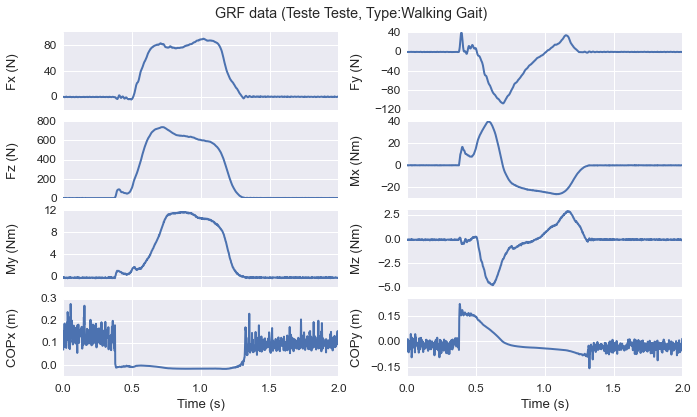

In [3]:
data, mh, ih = loadbsf(filename='./../data/AMTIdata.bsf', plot=1)

The headers (metadata from the .bsf file) are objects of the class AMTIbsf. You can visualize all the information from the headers typing for instance `mh` or ih[0]. Each information can be accessed as a propertiy of the header typing for instance `mh.rate`. The headers can also be acessed as dictionaries typing for instance `mh.__dict__`.

In [4]:
mh.rate

500

In [5]:
mh


Main header:
cmnfl : 
delayks : 0
height : 0.0
instHeadCount : 1
name : Teste Teste
num_of_instrs : 0
num_of_plats : 1
numDatasets : 1000.0
post_trig : 0
pre_trig : 0
protocol : Balance.pro
rate : 500
sex : 
size_header : 968
sub_dob : 
test_by : Damiana
test_date : 8/11/2015
test_type : Type:Walking Gait
TNC : 6
trigchan : 2
trigmth : 1
trigval : 0.0
trl_lth : 2.0
trl_num : 5
trldscfl : Unknown
units : 1
version_number : 105
weight : 0.0
wtmth : 0
zmth : 0


In [6]:
ih[0].__dict__

{'MNC': 32,
 'acqrange': array([ 634.9206543,  634.9206543,  634.9206543,  634.9206543,
         634.9206543,  634.9206543]),
 'ampgain': array([ 7086.60009766,  7480.29980469,  7874.        ,  8267.70019531,
         8661.40039062,  9055.09960938]),
 'chans': array([0, 1, 2, 3, 4, 5]),
 'coord': array([ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.]),
 'data_end_chan': 5,
 'data_strt_chan': 0,
 'end_time': 0.0,
 'end_val': 0.0,
 'extvoltage': array([ 10.02647972,   9.99201298,  10.01435947,  10.0100193 ,
         10.01329136,  10.02140045]),
 'interdist': array([ 0.,  0.,  0.]),
 'latency_period': 0.0,
 'layout_num': 0,
 'length': 0.5999480213165282,
 'model': 'OPT400600-1000-STT',
 'num_chans': 6,
 'offset': array([ 0.,  0.,  0.]),
 'post_trig_time': 0.0,
 'rate': 0,
 'sens': array([ 1.,  1.,  1.,  1.,  1.,  1.]),
 'ser_num': 9538,
 'size_header': 948,
 'tr_end_chan': 5,
 'tr_strt_chan': 0,
 'trig_val': 0.0,
 'trigger_time': 0.0,
 'width': 0.40

## Function `AMTIbsf.py`

In [ ]:
# %load ./../functions/AMTIbsf.py
"""Reads .bsf file (version 105) from AMTI NetForce software.

    This module reads .bsf file (version 105) from AMTI NetForce software and
    extracts the file metadata and data from force platforms.
    The typical use of this module is, for example:
    
        from AMTIbsf import loadbsf
        data, mh, ih = loadbsf(filename, plot=1, axs=None)
    
    Or from command line, for example:
    
        python AMTIbsf.py filename
    
    Where:
    filename, plot, axs are: string with path and name of the file to be 
    opened; option to plot the data; and option with the plot axes handle.
    data, mh, ih are: numpy array with all the data; object Main header; 
    and object with all Instrument headers (iH[0], iH[1], ...).
    
    This code can also open the 'shfile' memory-mapped file by NetForce.
    
    All the data is converted to SI units.
"""

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.0"
__license__ = "MIT"

import sys
import mmap
from struct import unpack
import numpy as np


def loadbsf(filename, plot=1, axs=None):
    """Load .bsf file (version 105) from AMTI NetForce software.

    Parameters
    ----------
    filename  : string
        Path and name of the .bsf file (version 105) to be opened.
    plot  : int or bool, optional (default = 1)
        If 1 (True), plot data in matplotlib figure.
    axs  : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    data  : 2-D numpy array (possibly [Fx, Fy, Fz, Mx, My, Mz])
        Data is expressed in engineering units (N and Nm for a force plate).
    mh  : object
        Object with all the information from the Main header.
    ih  : object
        Object with all the information from the Instrument header(s).
        (ih[0], ih[1], ...)

    Notes
    -----
    The headers are objects of the class AMTIbsf. You can visualize all the
    information from the headers typing mh or ih[0]. Each information can be
    accessed as a property of the header typing for instance mh.rate
    The headers can also be accessed as dictionaries (useful for saving) typing
    mh.__dict__

    According to AMTI:
    "If the file version is 100 that means the file is packed the old way. If 
    the file version is 105 that means the file is packed the new way. Using 
    the old way all data was stored as bits and then rebuilt. Using the new way 
    the data is stored as doubles. This is because the new amplifiers process 
    the data in the amplifier itself and send up already processed data."

    This code can also open the 'shfile' memory-mapped file by NetForce.

    All the data is converted to SI units.

    See the NetForce Users Manual from AMTI [1]_
    See this IPython notebook [2]_

    References
    ----------
    .. [1] http://www.amti.biz/NetForce.aspx
    .. [2] https://github.com/demotu/BMC/blob/master/notebooks/AMTI_bsf_file.ipynb
    
    Examples
    --------
    >>> from AMTIbsf import loadbsf
    >>> data, mh, ih = loadbsf(filename='./../data/AMTIdata.bsf', plot=1)

    """

    MNC = 32  # Maximum number of channels defined by AMTI
    lbforce_per_N = 1.0/4.44822162  # AMTI conversion factor (version 105)
    # this constant is derived from:
    # g = 9.80665  # standard acceleration of free fall in m/s2 by ISO 80000-3:2006
    # onelb = 0.45359237  # 1 lb in kg by International yard and pound

    plot = int(plot)  # in case of command line input

    if filename == 'shfile':  # memory-mapped file by NetForce
        try:
            # bug in mmap for windows: file can't be opened with unknown size
            # read at least up to the first instrument:
            nbytes = 4 + 968 + 948
            f = mmap.mmap(fileno=-1, length=nbytes, tagname='shfile')  
            f.seek(0, 0)
        except IOError as err:
            print('{0} I/O error: {1}'.format(filename, err))
            f.close()
            return
    else:  # file in the hard disk
        try:
            f = open(filename, 'rb')  
        except IOError as err:
            print('{0} I/O error: {1}'.format(filename, err))
            f.close()
            return

    # read Main header
    try:
        mh = ReadMainHeader(f)
    except:
        print('Error reading Main Header in %s.' %filename)
        f.close()
        return    
    
    if filename == 'shfile':
        try:
            # try to open for all bytes in file:
            nbytes = 4 + mh.size_header + 948*mh.instHeadCount + 8*int(mh.numDatasets*mh.TNC)
            f = mmap.mmap(fileno=-1, length=nbytes, tagname='shfile')
        except IOError as err:
            pass
        try:
            # instrument header may have size < 948, do not try to open for all bytes yet:
            nbytes = 4 + mh.size_header + 948*mh.instHeadCount + 4*int(mh.numDatasets*mh.TNC)
            f = mmap.mmap(fileno=-1, length=nbytes, tagname='shfile')   
        except IOError as err:
            print('{0} I/O error: {1}'.format(filename, err))
            f.close()
            return

    # read Instrument header
    ih = []
    f.seek(4 + mh.size_header, 0)  # advances file to the first instrument header
    for i in range(mh.instHeadCount):
        try:
            ih.append(ReadInstHeader(f, MNC, mh.TNC))
        except:
            print('Error reading Instrument Header in %s.' %filename)
            f.close()
            return
        # go to the next instrument header
        f.seek(4 + mh.size_header + ih[i].size_header - f.tell(), 1)     

    # check the file size and adjust for the shfile:
    current = f.tell()
    f.seek(0, 2)
    filesize = f.tell()
    if filesize - current != 8*int(mh.numDatasets*mh.TNC):
        if filename == 'shfile':  # open the file for all its bytes
            try:
                nbytes = current + 8*int(mh.numDatasets*mh.TNC)
                f = mmap.mmap(fileno=-1, length=nbytes, tagname='shfile')
            except:
                print('Error: unnexpected number of bytes for data in %s.' %filename)
                f.close()
                return
        else:
            print('Error: unnexpected number of bytes for data in %s.' %filename)
            f.close()
            return
    f.seek(current, 0)

    # read data
    try:
        data = unpack('<'+int(mh.numDatasets*mh.TNC)*'d', f.read(int(mh.numDatasets*mh.TNC)*8))
    except:
        print('Error reading data in %s.' %filename)
        f.close()
        return
    data = np.array(data).reshape((mh.numDatasets, mh.TNC))
    # In NetForce file, data is always in Imperial units, scale factor for force platform:
    scale = np.array([1, 1, 1, 0.0254, 0.0254, 0.0254]) / lbforce_per_N
    for i in range(mh.num_of_plats):
        # In the NetForce file version 105, raw data is already converted
        data[:, ih[i].chans] = data[:, ih[i].chans] * scale

    f.close()

    if plot:
        plotGRF(data, mh, ih, axs=None)

    return data, mh, ih


def deco(string):
    """Custom decoder for reading .bsf file from AMTI NetForce software."""
    return string.decode('utf-8').partition('\x00')[0] 


def print_attr(classe, header='\nHeader:'):
    """print class attributes (variables) and their values."""
    attributes = sorted([attr for attr in vars(classe) if not attr.startswith('__')], key=str.lower)
    print(header)
    for attr in attributes:
        print(attr, ':', classe.__dict__[attr])


def plotGRF(grf, mh, ih, axs=None):
    """Plot ground reaction forces of a .bsf file (version 105) from AMTI NetForce software.
    """
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
        return

    time = np.linspace(0, (grf.shape[0]-1)/mh.rate, grf.shape[0])
    if axs is None:
        fig, axs = plt.subplots(4, 2, figsize=(10, 6), sharex=True)
        fig.subplots_adjust(left = 0.1, right = 0.96, top = 0.92, wspace = 0.25, hspace = 0.15)
    axs = axs.flatten()
    ylabel = ['Fx (N)', 'Fy (N)', 'Fz (N)',
              'Mx (Nm)', 'My (Nm)', 'Mz (Nm)', 'COPx (m)', 'COPy (m)']  
    for p in range(int(grf.shape[1]/6)):
        cop = np.vstack((-grf[:, 4 + 6*p], grf[:, 3 + 6*p])/grf[:, 2 + 6*p]).T
        for i, axi in enumerate(axs):
            if i < 6:
                axi.plot(time, grf[:, i + 6*p], label='FP %d'%p)
            else:
                axi.plot(time, cop[:, i - 6], label='FP %d'%p)
            if p == 0:
                axi.set_ylabel(ylabel[i])
                axi.yaxis.set_major_locator(plt.MaxNLocator(4))
                axi.yaxis.set_label_coords(-.16, 0.5)
    if p:
        axs[7].legend(loc='best', frameon=True, framealpha=.5)
    axs[6].set_xlabel('Time (s)')
    axs[7].set_xlabel('Time (s)')
    title = 'GRF data'
    if len(mh.name) and len(mh.test_type):
        title = 'GRF data (%s, %s)' %(mh.name, mh.test_type)
    plt.suptitle(title, fontsize='x-large')
    #plt.tight_layout(h_pad=.1)  # doesn't work well with suptitle
    plt.show()


class ReadMainHeader:
    """Reader of the Main header of a .bsf file (version 105) from AMTI NetForce software.
    
    A class is used for the convenience of introspection of the header metadata.
    """
    def __init__(self, f):

        f.seek(0, 0)  # just in case
        self.version_number = unpack('<i', f.read(4))[0]             # .bsf file version number
        if self.version_number != 105:
            print('Error: this function was written for NetForce file version 105;' 
                  ' the version of this file seems to be %d.' %self.version_number)
            sys.exit(1)
        self.size_header = unpack('<i', f.read(4))[0]                # Size of the structure in bytes
        self.num_of_plats = unpack('<i', f.read(4))[0]               # Number of active platforms
        self.num_of_instrs = unpack('<i', f.read(4))[0]              # Number of active instruments
        name = deco(unpack('<100s', f.read(100))[0])                 # Subject's name
        self.name = "".join(name.split(", ")[::-1]).strip()          # name is saved as 'Lastname, Firstname'
        self.test_date = deco(unpack('<12s', f.read(12))[0 ])        # Test date
        self.sub_dob = deco(unpack('<12s', f.read(12))[0])           # Subject's date of birth
        self.weight = unpack('<d', f.read(8))[0]                     # Subject's weight
        self.height = unpack('<d', f.read(8))[0]                     # Subject's height
        self.sex = deco(unpack('<4c', f.read(4))[0])                 # Subject's sex
        self.trl_num = unpack('<i', f.read(4))[0]                    # Number of trials
        self.trl_lth = unpack('<d', f.read(8))[0]                    # Length of the trial in seconds
        self.zmth = unpack('<i', f.read(4))[0]                       # Zero method
        self.wtmth = unpack('<i', f.read(4))[0]                      # Weight method
        self.delayks = unpack('<i', f.read(4))[0]                    # Delay after keystroke
        self.trigmth = unpack('<i', f.read(4))[0]                    # Trigger method, 0:keystroke, 1:by chan, 2:external
        self.trigchan = unpack('<i', f.read(4))[0]                   # Triggering platform
        self.pre_trig = unpack('<i', f.read(4))[0]                   # Pre trigger values
        self.post_trig = unpack('<i', f.read(4))[0]                  # Post trigger values
        self.trigval = unpack('<d', f.read(8))[0]                    # Trigger value 
        f.seek(4, 1)                                                 # 4 unidentified bytes
        self.rate = unpack('<i', f.read(4))[0]                       # Rate of acquisition
        self.protocol = deco(unpack('<150s', f.read(150))[0])        # Protocol file used
        self.test_type = deco(unpack('<200s', f.read(200))[0])       # Type of test, e.g., eyes open
        self.cmnfl = deco(unpack('<150s', f.read(150))[0])           # A file name which contains comments
        self.trldscfl = deco(unpack('<150s', f.read(150))[0])        # A file name with trial descriptions
        self.test_by = deco(unpack('<100s', f.read(100))[0])         # Examiner's name
        f.seek(2, 1)                                                 # 2 unidentified bytes
        self.units = unpack('<i', f.read(4))[0]                      # Units where 0 is English and 1 is metric

        self.instHeadCount = self.num_of_plats + self.num_of_instrs  # Instrument header count
        self.numDatasets = self.trl_lth * self.rate                  # Number of data sets in the file
        # Total number of channels:
        TNC = 0                                  
        for i in range(self.instHeadCount):
            instsize_header = unpack('<l', f.read(4))[0]
            f.seek(28, 1)
            TNC += unpack('<l', f.read(4))[0]    # add number of channels in this instrumemt
            if i < self.instHeadCount - 1:
                f.seek(instsize_header - 40, 1)  # go to next instrument header
            else:
                f.seek(4 + self.size_header, 0)  # rewinds file to first instrument header
        self.TNC = TNC

    def __repr__(self):
        print_attr(self, header='\nMain header:')
        return '\n'


class ReadInstHeader:
    """Reader of the Instrument header of a .bsf file (version 105) from AMTI NetForce software.
    
       In version 105, length is always in inch, do the conversion to meter.
       WARNING: AMTI NetForce version 3.5.3 uses 39.4 instead of 39.37 to convert inch to meter.

       A class is used for the convenience of introspection of the header metadata.
    """
    def __init__(self, f, MNC, TNC):
            
        self.MNC = MNC                                                        # Maximum number of channels

        self.size_header = unpack('<i', f.read(4))[0]                         # Size of the structure in bytes
        self.ser_num = unpack('<i', f.read(4))[0]                             # Serial number of the instrument or platform
        self.layout_num = unpack('<i', f.read(4))[0]                          # The layout or platform number
        self.model = deco(unpack('<20s', f.read(20))[0])                      # Name of the instrument
        self.num_chans = unpack('<i', f.read(4))[0]                           # Number of channels
        self.tr_strt_chan = unpack('<i', f.read(4))[0]                        # True start channel, depends on hardware setup
        self.tr_end_chan = unpack('<i', f.read(4))[0]                         # True end channel, depends on hardware setup
        self.data_strt_chan = unpack('<i', f.read(4))[0]                      # Start channel in the data file
        self.data_end_chan = unpack('<i', f.read(4))[0]                       # End channel in the data file
        self.length = unpack('<f', f.read(4))[0] * 0.0254                     # Length of the platform
        self.width = unpack('<f', f.read(4))[0] * 0.0254                      # Width of the platform
        self.offset = np.array(unpack('<fff', f.read(3*4))) / 39.4            # Instrument x,y,z offset
        self.sens = np.array(unpack('<'+MNC*'f', f.read(MNC*4))[:TNC])        # Sensitivities (possible 32 channels)
        self.chans = np.array(unpack('<'+MNC*'i', f.read(MNC*4))[:TNC])       # Channel numbers (possible 32 channels)
        self.coord = np.array(unpack('<'+16*'f', f.read(16*4)))               # Coordinate transformation
        self.interdist = np.array(unpack('<fff', f.read(3*4))) / 39.4         # x,y,z distances from the previous platform
        self.ampgain = np.array(unpack('<'+MNC*'f', f.read(MNC*4))[:TNC])     # Amplifier Gains (possible 32 channels)   
        self.extvoltage = np.array(unpack('<'+MNC*'f', f.read(MNC*4))[:TNC])  # Excitation voltage
        self.acqrange = np.array(unpack('<'+MNC*'f', f.read(MNC*4))[:TNC])    # Acquisition card range (bits/volt)
        self.zero_period = unpack('<f', f.read(4))[0]                         # Tz
        self.latency_period = unpack('<f', f.read(4))[0]                      # Tl
        self.trigger_time = unpack('<f', f.read(4))[0]                        # Ttrig
        self.end_time = unpack('<f', f.read(4))[0]                            # Tend
        self.post_trig_time = unpack('<f', f.read(4))[0]                      # Tpost
        self.zero = np.array(unpack('<'+MNC*'i', f.read(MNC*4))[:TNC])        # Zero values
        self.rate = unpack('<i', f.read(4))[0]                                # Data set interval   
        self.trig_val = unpack('<f', f.read(4))[0]                            # Trigger value
        self.end_val = unpack('<f', f.read(4))[0]                             # End value

    def __repr__(self):
        print_attr(self, header='\nInstrument header:')
        return '\n'


if __name__ == "__main__":
    loadbsf(*sys.argv[1:])